In [1]:
import os
import math
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils_feature_engineering import *

#### Load data

In [2]:
# path
path = 'DATA RAW'
# application_train
application_train_path = f'../{path}/dseb63_application_train.csv'
application_train = pd.read_csv(application_train_path)
application_train.drop(columns='Unnamed: 0', inplace=True)

# application_test
application_test_path = f'../{path}/dseb63_application_test.csv'
application_test = pd.read_csv(application_test_path)
application_test.drop(columns='Unnamed: 0', inplace=True)

##### Load train + tvt = train_filtered for features evaluation
##### Load train/test for applying mean encoding

In [3]:
# filter by tvt code
pdf_tvt_extend = pd.read_pickle("pdf_tvt_extend.pkl", compression="bz2")
application_train_filtered = (pdf_tvt_extend.query("tvt_code == 'train'")
                      .merge(application_train[["SK_ID_CURR"]], on="SK_ID_CURR")
                      .drop(columns=["tvt_code"]))
application_train_filtered.head()

# Chỉ giữ lại cột SK_ID_CURR và biến target
# application_train_filtered = application_train[['SK_ID_CURR', 'TARGET']]
# application_train_filtered

,SK_ID_CURR,TARGET
0,278621,0
1,139008,0
2,138348,0
3,53466,0
4,27272,0


In [4]:
# installments_payments 
installments_payments_path = f'../{path}/dseb63_installments_payments.csv'
installments_payments = pd.read_csv(f'../{path}/dseb63_installments_payments.csv')
installments_payments.head()

,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR
0,1054186,1.0,6,-1180.0,-1187.0,6948.360,6948.360,147397.0
1,2452854,1.0,21,-546.0,-552.0,11302.605,11302.605,147397.0
2,1054186,1.0,2,-1300.0,-1307.0,6948.360,6948.360,147397.0
3,1682318,1.0,2,-240.0,-243.0,7374.510,7374.510,147397.0
4,2452854,1.0,10,-876.0,-882.0,11302.605,11302.605,147397.0


#### Preprocessing

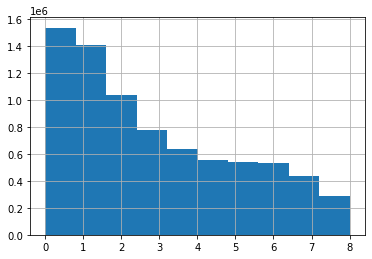

In [5]:
# Draw a histogram of the "DAYS_INSTALMENT" column divided by -365 to convert units to years and reverse the sign
(installments_payments["DAYS_INSTALMENT"] / -365).hist()
plt.show()

In [6]:
# Convert values to years
installments_payments["DAYS_INSTALMENT_TO_YEARS"] = installments_payments["DAYS_INSTALMENT"] / -365

# Drop the "DAYS_INSTALMENT" column from the DataFrame
installments_payments.drop(columns=["DAYS_INSTALMENT"], inplace=True)

In [7]:
# Calculate the difference between "AMT_PAYMENT" and "AMT_INSTALMENT"
installments_payments["AMT_PAYMENT"].fillna(0, inplace=True)
installments_payments["diff_amount"] = installments_payments["AMT_PAYMENT"] - installments_payments["AMT_INSTALMENT"]

# Display descriptive statistics for the "diff_amount" column
installments_payments["diff_amount"].describe()


count    7.744757e+06
mean     1.255704e+02
std      1.891506e+04
min     -2.424726e+06
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.630909e+06
Name: diff_amount, dtype: float64

In [8]:
installments_payments.duplicated().sum()

0

In [9]:
null_cols = installments_payments.isnull().sum()
null_cols[null_cols>0].sort_values(ascending=False)

DAYS_ENTRY_PAYMENT    1639
AMT_INSTALMENT           1
SK_ID_CURR               1
diff_amount              1
dtype: int64

In [10]:
installments_payments.fillna(0, inplace= True)

In [11]:
installments_payments.isnull().sum()

SK_ID_PREV                  0
NUM_INSTALMENT_VERSION      0
NUM_INSTALMENT_NUMBER       0
DAYS_ENTRY_PAYMENT          0
AMT_INSTALMENT              0
AMT_PAYMENT                 0
SK_ID_CURR                  0
DAYS_INSTALMENT_TO_YEARS    0
diff_amount                 0
dtype: int64

#### Numerical features

In [12]:
# get list numerical attributes
series_type = installments_payments.dtypes
ls_num = series_type[series_type == "int64"].index.tolist()
ls_num = [col for col in ls_num if col not in ["SK_ID_PREV", "SK_ID_CURR"]]
ls_num

['NUM_INSTALMENT_NUMBER']

In [13]:
# Aggregate data from the "NUM_INSTALMENT_NUMBER" column by "SK_ID_CURR"
pdf_agg02 = agg_common_data(installments_payments[["SK_ID_CURR", "NUM_INSTALMENT_NUMBER"]], ["max", "min", "sum", "mean", "std"], main_key="SK_ID_CURR")

# Evaluate features
eval_agg02 = feature_evaluate(application_train_filtered, pdf_agg02)


{'NUM_INSTALMENT_NUMBER': ['max', 'min', 'sum', 'mean', 'std']}

After agg: (180733, 5)


In [14]:
eval_agg02

,name,auc,corr,coverage
2,NUM_INSTALMENT_NUMBER_sum,0.510122,-0.018516,1.0000
3,NUM_INSTALMENT_NUMBER_mean,0.509591,-0.011153,1.0000
4,NUM_INSTALMENT_NUMBER_std,0.507612,0.003923,0.9978
0,NUM_INSTALMENT_NUMBER_max,0.504645,0.005745,1.0000
1,NUM_INSTALMENT_NUMBER_min,0.500182,-0.004987,1.0000


#### Continuous features

In [15]:
# get list continuous attributes
series_type = installments_payments.dtypes
ls_con = series_type[series_type == "float64"].index.tolist()

# remove 'SK_ID_CURR' if it exists in the list
ls_con = [col for col in ls_con if col != 'SK_ID_CURR']

ls_con


['NUM_INSTALMENT_VERSION',
 'DAYS_ENTRY_PAYMENT',
 'AMT_INSTALMENT',
 'AMT_PAYMENT',
 'DAYS_INSTALMENT_TO_YEARS',
 'diff_amount']

In [16]:
# Select columns "SK_ID_PREV", "SK_ID_CURR", and the list of variables (ls_con) from the DataFrame pdf_data
pdf_con = installments_payments[["SK_ID_PREV", "SK_ID_CURR"] + ls_con].copy()
pdf_con.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_INSTALMENT_TO_YEARS,diff_amount
0,1054186,147397.0,1.0,-1187.0,6948.360,6948.360,3.232877,0.0
1,2452854,147397.0,1.0,-552.0,11302.605,11302.605,1.495890,0.0
2,1054186,147397.0,1.0,-1307.0,6948.360,6948.360,3.561644,0.0
3,1682318,147397.0,1.0,-243.0,7374.510,7374.510,0.657534,0.0
4,2452854,147397.0,1.0,-882.0,11302.605,11302.605,2.400000,0.0


In [17]:
print(pdf_con.shape)

(7744758, 8)


In [18]:
# Aggregate data
pdf_agg03 = agg_common_data(pdf_con[["SK_ID_CURR"] + ls_con], ["max", "min", "sum", "mean", "std"], main_key="SK_ID_CURR")

# Evaluate features of the aggregated data and save the results in the eval_agg03 variable
eval_agg03 = feature_evaluate(application_train_filtered, pdf_agg03)

{'NUM_INSTALMENT_VERSION': ['max', 'min', 'sum', 'mean', 'std'],
 'DAYS_ENTRY_PAYMENT': ['max', 'min', 'sum', 'mean', 'std'],
 'AMT_INSTALMENT': ['max', 'min', 'sum', 'mean', 'std'],
 'AMT_PAYMENT': ['max', 'min', 'sum', 'mean', 'std'],
 'DAYS_INSTALMENT_TO_YEARS': ['max', 'min', 'sum', 'mean', 'std'],
 'diff_amount': ['max', 'min', 'sum', 'mean', 'std']}

After agg: (180733, 30)


In [19]:
eval_agg03

,name,auc,corr,coverage
24,DAYS_INSTALMENT_TO_YEARS_std,0.560559,-0.058563,0.9978
16,AMT_PAYMENT_min,0.559811,-0.034918,1.0000
9,DAYS_ENTRY_PAYMENT_std,0.559543,-0.057882,0.9978
6,DAYS_ENTRY_PAYMENT_min,0.559312,0.056824,1.0000
20,DAYS_INSTALMENT_TO_YEARS_max,0.559081,-0.056656,1.0000
28,diff_amount_mean,0.558098,-0.027115,1.0000
8,DAYS_ENTRY_PAYMENT_mean,0.554394,0.043270,1.0000
23,DAYS_INSTALMENT_TO_YEARS_mean,0.553610,-0.042686,1.0000
27,diff_amount_sum,0.551073,-0.027672,1.0000
7,DAYS_ENTRY_PAYMENT_sum,0.547302,0.035006,1.0000


#### Save features

In [20]:
# Combine features from pdf_agg02 and pdf_agg03 to create pdf_feat
pdf_feat = pdf_agg02.join(pdf_agg03)

print(pdf_feat.shape)

(180733, 35)


In [21]:
fname = "installments_payments"

fname = os.path.join("features", "{}.pkl.bz2".format(fname))
pdf_feat.to_pickle(fname, compression="bz2")
print("Store features completed!")

Store features completed!
